In [ ]:
#reference 1 : https://www.kaggle.com/kaushiksuresh147/performance-analysis-of-top10-crypto-s-in-oct-2021  
#reference 2 : https://www.kaggle.com/gneakbulut/bitcoin-price-prediction-rnn-and-lstm  
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from datetime import datetime, timedelta
import re

df = pd.read_csv("/content/sample_data/XRP.csv")

## 날짜 변환
df["Date"] = pd.to_datetime(df["Date"]) 

## 컬럼명 변환
df.rename(columns={"Price":"Close", "Vol.":"Vol", "Change %":"Change"}, inplace=True)

## "-" 값을 Null로 치환
#df["Vol"] = df["Vol"].str.replace("-",-1)
df = df.replace("-", -1)

## Vol값의 카테고리 확인
ss =df["Vol"].str[-1:]
label = ss.groupby(ss).first()
#print(label.apply(list))


## Vol값 문자 제거
idx = 0
for vol, change in zip(df["Vol"], df["Change"]):
    if(vol != -1):
      volUnit = vol[len(vol) - 1]
      if(volUnit == "M"):
          df["Vol"][idx] = float(vol[:-1]) * 1000
      elif(volUnit == "K"):          
          df["Vol"][idx] = float(vol[:-1]) * 100
      elif(volUnit == "B"):
          df["Vol"][idx] = float(vol[:-1]) * 10     
    idx = idx + 1

## Vol값에 문자가 제거 되었는지 확인
df.sort_values(by=["Vol"])

## Change 퍼센트 문자 제거
df["Change"] = df["Change"].str.replace("%","")

## 타입변경
df = df.astype({"Vol":"float"})
df = df.astype({"Change":"float"})

df


,Date,Close,Open,High,Low,Vol,Change
0,2021-11-02,1.13215,1.09204,1.14612,1.08558,480670.0,3.67
1,2021-11-01,1.09205,1.11265,1.13100,1.07103,501800.0,-1.84
2,2021-10-31,1.11257,1.08409,1.15205,1.07002,823880.0,2.63
3,2021-10-30,1.08406,1.08107,1.11542,1.06318,479640.0,0.29
4,2021-10-29,1.08098,1.05806,1.09004,1.05521,484840.0,2.18
...,...,...,...,...,...,...,...
2472,2015-01-26,0.01469,0.01700,0.01750,0.01469,-1.0,-13.59
2473,2015-01-25,0.01700,0.01739,0.01739,0.01560,-1.0,-2.24
2474,2015-01-24,0.01739,0.01600,0.01739,0.01500,-1.0,8.69
2475,2015-01-23,0.01600,0.01602,0.01700,0.01600,-1.0,-0.12


In [ ]:
import calendar

def getWeekFirstAndLastDay(date):
    date_obj = datetime.strptime(date, '%Y-%m-%d')

    start_of_week = date_obj - timedelta(days=date_obj.weekday())  # Monday
    end_of_week = start_of_week + timedelta(days=6)
    #dt = date.strftime("%Y-%m-%d")
    #return start_of_week
    #return (start_of_week, end_of_week)
    return (start_of_week.strftime("%Y-%m-%d"), end_of_week.strftime("%Y-%m-%d"))



def getMonthDataMean(date):    
    yy = date.strftime("%Y")
    mm = date.strftime("%m")
    last_day = calendar.monthrange(int(yy), int(mm))[1]

    month_str = yy + mm + "01"
    month_end = yy + mm + str(last_day)

    month_df = df[(df['Date']>=month_str) & (df['Date']<=month_end)]
    
    return str(month_df["Vol"].mean())


In [ ]:
index = 0
## 복사한 이유 : 기존 df로하면 데이터가 실시간으로 반영되서 주간 월간 평균이 변경될수 있기때문에
bf_df = df.copy()
for date, vol in zip(bf_df["Date"], bf_df["Vol"]):
    if(vol < 1):
        dt = date.strftime("%Y-%m-%d")
        strDt, endDt = getWeekFirstAndLastDay(dt)

        week_df = bf_df[(bf_df['Date']>=strDt) & (bf_df['Date']<=endDt)]
        ##-1로 되어있는 거래량을 주간단위로 평균 구하기
        vol_mean = week_df["Vol"].mean()
        #print(type(vol_mean))
        ##주간단위로 평균을 구했을때 -1이면 거래량을 월간단위로 평균 구하기
        
        if(vol_mean < 1):          
            df["Vol"][index] = getMonthDataMean(date)
        else:
            df["Vol"][index] = vol_mean
    index = index + 1

#df.to_excel('text.xlsx')
#df.sort_values(by=["Vol"])

In [ ]:
## 데이터 확인
#df.sort_values(by=["Vol"])
df["Vol"][(df["Vol"] < 2)]

#################### 데이터 가공 끝(전처리) ########################

2011    1.000000
2135    1.000000
2210    1.000000
2245    1.000000
2310    1.000000
2312    1.000000
2360    1.000000
2361    1.000000
2381    1.000000
2433    1.000000
2439    1.678571
2440    1.774235
2442    1.873315
2443    1.975933
Name: Vol, dtype: float64

In [ ]:
grouped_data = df.groupby('Date', as_index = False).mean()
grouped_data

,Date,Close,Open,High,Low,Vol,Change
0,2015-01-22,0.01602,0.01523,0.01750,0.01523,47.106143,5.19
1,2015-01-23,0.01600,0.01602,0.01700,0.01600,42.732857,-0.12
2,2015-01-24,0.01739,0.01600,0.01739,0.01500,38.757143,8.69
3,2015-01-25,0.01700,0.01739,0.01739,0.01560,35.142857,-2.24
4,2015-01-26,0.01469,0.01700,0.01750,0.01469,32.857143,-13.59
...,...,...,...,...,...,...,...
2472,2021-10-29,1.08098,1.05806,1.09004,1.05521,484840.000000,2.18
2473,2021-10-30,1.08406,1.08107,1.11542,1.06318,479640.000000,0.29
2474,2021-10-31,1.11257,1.08409,1.15205,1.07002,823880.000000,2.63
2475,2021-11-01,1.09205,1.11265,1.13100,1.07103,501800.000000,-1.84


In [ ]:
#df.isna().sum()
#df.sort_values(by=["Date"])
#len(df)
#Train and Test Split
train_size = int(len(grouped_data) * 0.9)
test_size = len(grouped_data) - train_size
df_train = grouped_data.iloc[0:train_size, :]
df_test = grouped_data.iloc[train_size:len(df), :]
print("Train size: {}, Test size: {}, Total size: {}".format(len(df_train), len(df_test), len(df)))

Train size: 2229, Test size: 248, Total size: 2477


In [ ]:
df_train

,Date,Close,Open,High,Low,Vol,Change
0,2015-01-22,0.01602,0.01523,0.01750,0.01523,47.106143,5.19
1,2015-01-23,0.01600,0.01602,0.01700,0.01600,42.732857,-0.12
2,2015-01-24,0.01739,0.01600,0.01739,0.01500,38.757143,8.69
3,2015-01-25,0.01700,0.01739,0.01739,0.01560,35.142857,-2.24
4,2015-01-26,0.01469,0.01700,0.01750,0.01469,32.857143,-13.59
...,...,...,...,...,...,...,...
2224,2021-02-23,0.47490,0.56581,0.57060,0.36720,42.200000,-16.07
2225,2021-02-24,0.46923,0.47613,0.49934,0.45168,15.600000,-1.19
2226,2021-02-25,0.43561,0.46849,0.48146,0.42599,10.800000,-7.17
2227,2021-02-26,0.42783,0.43592,0.45033,0.41300,14.200000,-1.79


In [ ]:
df_test

,Date,Close,Open,High,Low,Vol,Change
2229,2021-02-28,0.41528,0.43578,0.43789,0.39340,10.5,-4.69
2230,2021-03-01,0.44551,0.41566,0.45262,0.41226,927260.0,7.28
2231,2021-03-02,0.43582,0.44546,0.45414,0.42297,920490.0,-2.18
2232,2021-03-03,0.44844,0.43582,0.46723,0.43140,917030.0,2.90
2233,2021-03-04,0.48088,0.44844,0.49380,0.43623,18.3,7.23
...,...,...,...,...,...,...,...
2472,2021-10-29,1.08098,1.05806,1.09004,1.05521,484840.0,2.18
2473,2021-10-30,1.08406,1.08107,1.11542,1.06318,479640.0,0.29
2474,2021-10-31,1.11257,1.08409,1.15205,1.07002,823880.0,2.63
2475,2021-11-01,1.09205,1.11265,1.13100,1.07103,501800.0,-1.84


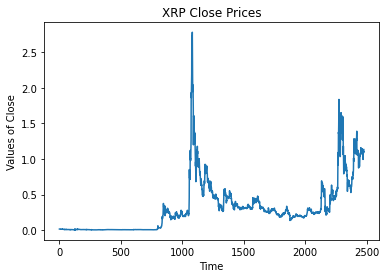

In [ ]:
data_plot = grouped_data.loc[:, ["Close"]].values
plt.plot(data_plot)
plt.xlabel("Time")
plt.ylabel("Values of Close")
plt.title("XRP Close Prices")
plt.show()

In [ ]:
dataset = df_train.loc[:, ["Close"]].values
dataset.shape

(2229, 1)

In [ ]:
#reshape
dataset = dataset.reshape(-1, 1)

#change type
dataset = dataset.astype("float32")
dataset.shape

(2229, 1)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(dataset)
data_scaled

array([[0.00448776],
       [0.00448056],
       [0.0049812 ],
       ...,
       [0.15561295],
       [0.1528108 ],
       [0.15565977]], dtype=float32)

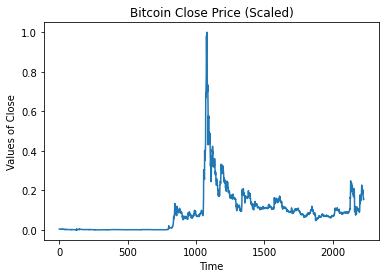

In [ ]:
plt.plot(data_scaled)
plt.xlabel("Time")
plt.ylabel("Values of Close")
plt.title("Bitcoin Close Price (Scaled)")
plt.show()

In [ ]:
data_scaled.shape[0]
data_scaled[11-10:11, 0]
len(data_scaled)

2229

In [ ]:
# Creating a data structure with 10 time_step and 1 output
X_train = []
y_train = []
time_step = 10
for i in range(time_step, data_scaled.shape[0]):
    X_train.append(data_scaled[i-time_step:i, 0])
    y_train.append(data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train shape:  (2219, 10)
y_train shape:  (2219,)


In [ ]:
# Reshaping to 3D
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)

X_train shape:  (2219, 10, 1)
y_train shape:  (2219,)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

In [ ]:
# Initialising the RNN ( with four layers)
regressor = Sequential()
function = "relu"

# Adding the first RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50, activation=function, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50, activation=function, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50, activation=function, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
# epoch= 100

Epoch 1/100
70/70 [==============================] - 4s 13ms/step - loss: 0.0079
Epoch 2/100
70/70 [==============================] - 1s 13ms/step - loss: 0.0018
Epoch 3/100
70/70 [==============================] - 1s 13ms/step - loss: 0.0013
Epoch 4/100
70/70 [==============================] - 1s 13ms/step - loss: 0.0014
Epoch 5/100
70/70 [==============================] - 1s 13ms/step - loss: 0.0012
Epoch 6/100
70/70 [==============================] - 1s 14ms/step - loss: 0.0012
Epoch 7/100
70/70 [==============================] - 1s 13ms/step - loss: 0.0011
Epoch 8/100
70/70 [==============================] - 1s 13ms/step - loss: 0.0010
Epoch 9/100
70/70 [==============================] - 1s 13ms/step - loss: 0.0013
Epoch 10/100
70/70 [==============================] - 1s 13ms/step - loss: 0.0010
Epoch 11/100
70/70 [==============================] - 1s 14ms/step - loss: 7.8799e-04
Epoch 12/100
70/70 [==============================] - 1s 15ms/step - loss: 0.0011
Epoch 13/100
70/70 [=

In [ ]:
real_xrp_price = df_test.loc[:, ["Close"]].values

In [ ]:
real_xrp_price.shape

(248, 1)

In [ ]:
df_total = pd.concat((df_train['Close'], df_test['Close']), axis = 0)
inputs = df_total[len(df_total) - len(df_test) - time_step:].values.reshape(-1,1)
inputs = scaler.transform(inputs)  # min max scaler

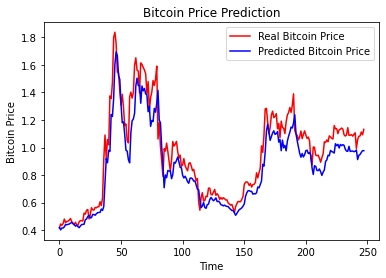

In [ ]:
X_test = []
for i in range(time_step, inputs.shape[0]):
    X_test.append(inputs[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_xrp_price = regressor.predict(X_test)
predicted_xrp_price = scaler.inverse_transform(predicted_xrp_price)

# Visualising the results
plt.plot(real_xrp_price, color = 'red', label = 'Real Bitcoin Price')
plt.plot(predicted_xrp_price, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

In [ ]:
##Long Short Time Memory (LSTM)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_size = int(len(grouped_data) * 0.90)
test_size = len(grouped_data) - train_size
df_train = grouped_data.iloc[0:train_size, :]
df_test = grouped_data.iloc[train_size:len(grouped_data), :]
print("DF_Train size: {}, DF_Test size: {}". format(len(df_train), len(df_test)))

DF_Train size: 2229, DF_Test size: 248


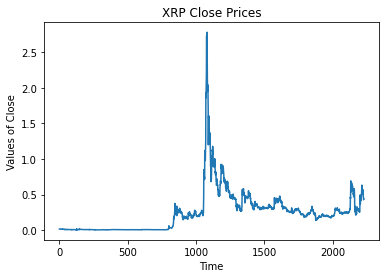

In [ ]:
data_plot = df_train.loc[:, ["Close"]].values
plt.plot(data_plot)
plt.xlabel("Time")
plt.ylabel("Values of Close")
plt.title("XRP Close Prices")
plt.show()

In [ ]:
dataset = df_train.loc[:, ["Close"]].values
dataset.shape

(2229, 1)

In [ ]:
#reshape
dataset = dataset.reshape(-1, 1)

#change type
dataset = dataset.astype("float32")
dataset.shape

(2229, 1)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(dataset)

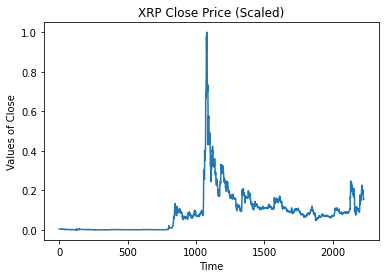

In [ ]:
plt.plot(data_scaled)
plt.xlabel("Time")
plt.ylabel("Values of Close")
plt.title("XRP Close Price (Scaled)")
plt.show()

In [ ]:
# We divide the DATA_SCALED by Training %50, Test %50
train_size = int(len(data_scaled) * 0.50)
test_size = len(data_scaled) - train_size
data_scaled_train = data_scaled[0:train_size, :]
data_scaled_test = data_scaled[train_size:len(data_scaled), :]

print("data_scaled_train size: {}\ndata_scaled_test size: {}". format(len(data_scaled_train), len(data_scaled_test)))
print("data_scaled_train shape: {}\ndata_scaled_test shape: {}". format(data_scaled_train.shape, data_scaled_test.shape))

data_scaled_train size: 1114
data_scaled_test size: 1115
data_scaled_train shape: (1114, 1)
data_scaled_test shape: (1115, 1)


In [ ]:
# Creating a data structure with 10 time_step and 1 output (TRAIN)
time_step = 10
dataX = []
dataY = []
for i in range(len(data_scaled_train) - time_step - 1):
    a = data_scaled_train[i:(i + time_step), 0]
    dataX.append(a)
    dataY.append(data_scaled_train[i + time_step, 0])
trainX = np.array(dataX)
trainY = np.array(dataY)

print("trainX shape: {}\ntrainY shape: {}". format(trainX.shape, trainY.shape))

trainX shape: (1103, 10)
trainY shape: (1103,)


In [ ]:
# Creating a data structure with 10 time_step and 1 output (TEST)
dataX = []
dataY = []
for i in range(len(data_scaled_test) - time_step -1):
    a = data_scaled_test[i:(i + time_step), 0]
    dataX.append(a)
    dataY.append(data_scaled_test[i + time_step, 0])
testX = np.array(dataX)
testY = np.array(dataY)

print("testX shape: {}\ntestY shape: {}". format(testX.shape, testY.shape))

testX shape: (1104, 10)
testY shape: (1104,)


In [ ]:
# Reshaping to 3D
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("X_train shape: ",trainX.shape)
print("X_test shape: ",testX.shape)

X_train shape:  (1103, 1, 10)
X_test shape:  (1104, 1, 10)


In [ ]:
##Modeling (LSTM)

In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

In [ ]:
# model
model = Sequential()
model.add(LSTM(256, input_shape = (1, time_step))) # 256 LSTM neuron(block)
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss= "mean_squared_error", optimizer = "adam")
model.fit(trainX, trainY, epochs=100, batch_size=50)

Epoch 1/100
23/23 [==============================] - 2s 10ms/step - loss: 0.0062
Epoch 2/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 3/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 4/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 5/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 6/100
23/23 [==============================] - 0s 9ms/step - loss: 8.9383e-04
Epoch 7/100
23/23 [==============================] - 0s 9ms/step - loss: 7.6000e-04
Epoch 8/100
23/23 [==============================] - 0s 9ms/step - loss: 7.2081e-04
Epoch 9/100
23/23 [==============================] - 0s 8ms/step - loss: 5.9530e-04
Epoch 10/100
23/23 [==============================] - 0s 9ms/step - loss: 5.3618e-04
Epoch 11/100
23/23 [==============================] - 0s 8ms/step - loss: 4.4746e-04
Epoch 12/100
23/23 [==============================] - 0s 9ms/step - loss: 4.1731e-04
Epoch 1

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               273408    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 273,665
Trainable params: 273,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_ = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform([testY])

# calculate root mean squared error
trainscore = math.sqrt(mean_squared_error(trainY_[0], trainPredict[:, 0]))
print("Train Score: %.2f RMSE" % (trainscore))
testscore = math.sqrt(mean_squared_error(testY_[0], testPredict[:, 0]))
print("Test Score: %.2f RMSE" % (testscore))

Train Score: 0.05 RMSE
Test Score: 0.04 RMSE


No handles with labels found to put in legend.


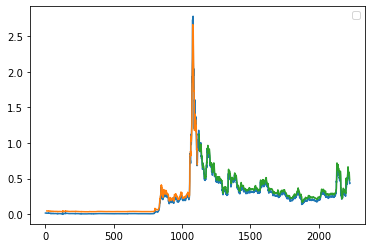

In [ ]:
# shifting train
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(trainPredict) + time_step, :] = trainPredict
# shifting test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (time_step * 2) + 1:len(data_scaled) - 1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
#plt.xlim(2500,3200)
plt.legend()
plt.show()

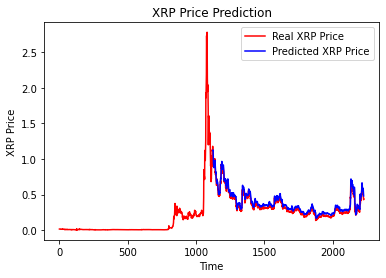

In [ ]:
# Visualising the results
plt.plot(scaler.inverse_transform(data_scaled), color = 'red', label = 'Real XRP Price')
plt.plot(testPredictPlot, color = 'blue', label = 'Predicted XRP Price')
plt.title('XRP Price Prediction')
plt.xlabel('Time')
plt.ylabel('XRP Price')
plt.legend()
plt.show()

In [ ]:
print(testPredictPlot)

[[       nan]
 [       nan]
 [       nan]
 ...
 [0.509462  ]
 [0.48175135]
 [       nan]]
